# Train LDA

In this notebook, we train one LDA model. This served as the foundation for the parallel code in src/sporc/lda_script.py and lda_helper.py.

Contents:
1. Setup
2. Train LDA 
3. Visualize LDA model
4. Evaluate
5. Recommending papers 

## 1. Setup

In [1]:
import pickle
import pandas as pd
import os
from sklearn.decomposition import PCA
import math
import seaborn as sns
from matplotlib.colors import ListedColormap
import multiprocessing as mp
import itertools
from ast import literal_eval
import numpy as np
import gensim
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import ParameterGrid
from matplotlib.gridspec import GridSpec
from sklearn.manifold import TSNE


import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

GLOBALS = pickle.load(open('../data/globals.p', 'rb'))
GLOBALS

{'absolute_filepaths': {'metadata': '/Volumes/ARCHIVES/Thesis/data/metadata.csv',
  'conversion_log': '/Volumes/ARCHIVES/Thesis/data/conversion_log.csv',
  'xml': '/Volumes/ARCHIVES/Thesis/data/xml/',
  'archive': '/Volumes/ARCHIVES/Thesis/data/archive/',
  'corpus': '/Volumes/ARCHIVES/Thesis/data/corpus/',
  'data': '/Volumes/ARCHIVES/Thesis/data/',
  'root': '/Volumes/ARCHIVES/Thesis/',
  'lda': '/Volumes/ARCHIVES/Thesis/src/sporc/lda/',
  'doc2vec': '/Volumes/ARCHIVES/Thesis/src/sporc/doc2vec/'},
 'start': 2009,
 'end': 2019}

Load metadata.

In [4]:
metadata = pd.read_csv(GLOBALS['absolute_filepaths']['metadata'],
                       dtype={'filename_parsed': str,
                              'in_range': bool, 
                              'has_xml': bool})
corpus_df = metadata[metadata['has_xml'] & metadata['in_range']][['filename_parsed', 'subcategories']].copy()
corpus_df['subcategories'] = corpus_df['subcategories'].apply(literal_eval) 
corpus_df

,filename_parsed,subcategories
19924,0901.0007,[astro-ph.CO]
19942,0901.0104,[astro-ph.GA]
19947,0901.0133,[astro-ph.GA]
19951,0901.0167,[astro-ph.HE]
19952,0901.0173,[astro-ph.CO]
...,...,...
179733,2001.01763,"[astro-ph.HE, astro-ph.IM]"
179765,2001.02170,"[astro-ph.HE, astro-ph.SR]"
179816,2001.02538,"[astro-ph.HE, astro-ph.SR]"
179946,2001.03530,"[astro-ph.EP, astro-ph.SR]"


## Prepare input

Here we prepare input data for LDA training. There are two inputs: 1) a dictionary where every unique term is assigned an index, and 2) bag-of-words representation of the corpus that was created using this dictionary.

In [5]:
class DocumentIterator(object):
    def load_documents(self):
        for filename in self.filenames:
            try: 
                yield np.load(filename)
            except Exception as e:
                print('Error! ' + str(e))

    def __init__(self, filenames):
        self.filenames = filenames

    def __iter__(self):
        self.documents = self.load_documents() # Reset the iterator
        return self

    def __next__(self):
        tokens = next(self.documents)
        return tokens
    
root = GLOBALS['absolute_filepaths']['corpus'] + 'abstracts/and_stopword_removal/'
corpus_ids = [os.path.splitext(os.path.basename(x))[0] for x in os.listdir(root) if x.endswith('.npy')]
corpus_filenames = [root + x + '.npy' for x in corpus_ids]
print('Number of files in corpus: ' + str(len(corpus_filenames)))
params = {'corpus': ['abstracts/basic_preprocessing',
                     'abstracts/and_stemming',
                     'abstracts/and_lemmatization',
                     'abstracts/and_stopword_removal',
                     'fulltexts/basic_preprocessing',
                     'fulltexts/and_stemming',
                     'fulltexts/and_lemmatization',
                     'fulltexts/and_stopword_removal'],
          'passes': [4],
          'num_topics': [6]}
tasks = list(ParameterGrid(params))
task = tasks[0]
print('The task we will test on is ' + str(task))

Number of files in corpus: 145437
The task we will test on is {'corpus': 'abstracts/basic_preprocessing', 'num_topics': 6, 'passes': 4}


We will work through the first task.

Create dictionary if it does not already exist. If it already exists, load it.

In [6]:
basepath = GLOBALS['absolute_filepaths']['lda'] + task['corpus'].replace('/', '_')
dictionary_path = basepath + '.dict'
corpus_iterator = DocumentIterator(corpus_filenames)
if not os.path.exists(dictionary_path):
    print('Creating dictionary...')
    dictionary = gensim.corpora.Dictionary(corpus_iterator)
    dictionary.save(dictionary_path)
else:
    print('Loading dictionary...')
    dictionary = gensim.corpora.Dictionary.load(dictionary_path)

INFO : loading Dictionary object from /Volumes/ARCHIVES/Thesis/src/sporc/lda/abstracts_basic_preprocessing.dict


Loading dictionary...


INFO : loaded /Volumes/ARCHIVES/Thesis/src/sporc/lda/abstracts_basic_preprocessing.dict


Create bag-of-words vectors if they do not already exist. If they do exist, load them.

In [7]:
bow_path = basepath + '.mm'
if not os.path.exists(bow_path):
    print('Creating bag of word vectors...')
    bow = [dictionary.doc2bow(tokens) for tokens in corpus_iterator]
    gensim.corpora.MmCorpus.serialize(bow_path, bow)
else:
    print('Loading bag of word vectors...')
    bow = gensim.corpora.MmCorpus(bow_path)

INFO : loaded corpus index from /Volumes/ARCHIVES/Thesis/src/sporc/lda/abstracts_basic_preprocessing.mm.index
INFO : initializing cython corpus reader from /Volumes/ARCHIVES/Thesis/src/sporc/lda/abstracts_basic_preprocessing.mm
INFO : accepted corpus with 145437 documents, 63957 features, 12138045 non-zero entries


Loading bag of word vectors...


In [31]:
tokens = np.load(GLOBALS['absolute_filepaths']['root'] + 'data/corpus/fulltexts/basic_preprocessing/0901.0104.npy')
trigrams_model[tokens]

In [17]:
trigrams[np.load(root + '0901.0104.npy')]

['present_new',
 'multi_fluid',
 'grid_code',
 'based',
 'relaxing',
 'scheme',
 'jin',
 'xin',
 'original',
 'scheme',
 'see',
 'trac',
 'pen',
 'pen',
 'et_al',
 'extended',
 'addition',
 'dynamically',
 'independent',
 'interacting_fluids',
 'dust',
 'diffusive',
 'cosmic_ray',
 'gas',
 'described_within',
 'fluid_approximation',
 'option',
 'add',
 'fluids',
 'easy_way',
 'code',
 'equipped',
 'shearing_box',
 'boundary_conditions',
 'selfgravity',
 'module',
 'ohmic_resistivity',
 'module',
 'well',
 'facilities',
 'useful_astrophysical',
 'fluid_dynamical',
 'simulations_code',
 'parallelized',
 'means',
 'library',
 'paper_present',
 'extension',
 'designed',
 'simulations',
 'diffusive_propagation',
 'cosmic_ray',
 'component',
 'magnetized']

## 2. Train LDA

Using LdaMulticore instead of LdaModel since this is several minutes faster with 3 cores instead of 1, confirmed using %%time. 

Can get a ballpark estimate of memory use by using the following [formula](https://miningthedetails.com/blog/python/lda/GensimLDA/) [(2nd source)](https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q5-i-am-getting-out-of-memory-errors-with-lsi-how-much-memory-do-i-need): 8 bytes * num_terms * num_topics * 3. Here we have 8 * 63957 * 6 * 3 = 9,209,808 bytes, or 9.21 MB of RAM. The memory footprint is affected by the dictionary size or number of topics, but not the number of training documents (as we streamed it in).

In [7]:
cpus = mp.cpu_count() - 1
print('Training LDAMulticore using ' + str(cpus) + ' CPUs.')
lda_model = gensim.models.LdaMulticore(corpus=bow, 
                                       workers=cpus,
                                       num_topics=6, 
                                       id2word=dictionary, 
                                       passes=4)
lda_model.save(GLOBALS['absolute_filepaths']['lda'] + 'lda.model')

INFO : using symmetric alpha at 0.16666666666666666
INFO : using symmetric eta at 0.16666666666666666
INFO : using serial LDA version on this node
INFO : running online LDA training, 6 topics, 4 passes over the supplied corpus of 145437 documents, updating every 6000 documents, evaluating every ~60000 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 3 processes


Training LDAMulticore using 3 CPUs.


INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/145437, outstanding queue size 1
INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/145437, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/145437, outstanding queue size 3
INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/145437, outstanding queue size 4
INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/145437, outstanding queue size 5
INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/145437, outstanding queue size 6
INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/145437, outstanding queue size 6
INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/145437, outstanding queue size 7
INFO : PROGRESS: pass 0, dispatched chunk #8 = documents up to #18000/145437, outstanding queue size 7
INFO : merging changes from 6000 documents into a model of 145437 documents
I

INFO : topic #4 (0.167): 0.009*"field" + 0.008*"magnetic" + 0.007*"energy" + 0.006*"ray" + 0.005*"model" + 0.005*"matter" + 0.005*"emission" + 0.005*"high" + 0.005*"data" + 0.005*"dark"
INFO : topic #5 (0.167): 0.011*"mass" + 0.007*"magnetic" + 0.006*"solar" + 0.005*"field" + 0.005*"stars" + 0.004*"ray" + 0.004*"using" + 0.004*"star" + 0.004*"observations" + 0.004*"model"
INFO : topic #1 (0.167): 0.008*"mass" + 0.007*"model" + 0.006*"stars" + 0.005*"models" + 0.005*"stellar" + 0.005*"data" + 0.005*"two" + 0.004*"high" + 0.004*"also" + 0.004*"using"
INFO : topic #3 (0.167): 0.011*"ray" + 0.009*"galaxies" + 0.008*"data" + 0.007*"galaxy" + 0.006*"z" + 0.006*"emission" + 0.005*"radio" + 0.005*"sample" + 0.004*"optical" + 0.004*"high"
INFO : topic diff=0.146492, rho=0.250000
INFO : PROGRESS: pass 0, dispatched chunk #27 = documents up to #56000/145437, outstanding queue size 9
INFO : PROGRESS: pass 0, dispatched chunk #28 = documents up to #58000/145437, outstanding queue size 10
INFO : mer

INFO : topic #0 (0.167): 0.011*"star" + 0.009*"galaxies" + 0.009*"stars" + 0.009*"mass" + 0.009*"emission" + 0.008*"gas" + 0.008*"formation" + 0.006*"line" + 0.006*"dust" + 0.006*"disk"
INFO : topic #2 (0.167): 0.009*"mass" + 0.007*"model" + 0.006*"models" + 0.005*"evolution" + 0.005*"dark" + 0.005*"field" + 0.004*"energy" + 0.004*"matter" + 0.004*"simulations" + 0.004*"stellar"
INFO : topic #3 (0.167): 0.011*"ray" + 0.010*"galaxies" + 0.009*"data" + 0.008*"z" + 0.007*"galaxy" + 0.006*"radio" + 0.005*"sample" + 0.005*"redshift" + 0.005*"using" + 0.005*"survey"
INFO : topic #5 (0.167): 0.010*"mass" + 0.008*"magnetic" + 0.008*"solar" + 0.007*"stars" + 0.005*"period" + 0.005*"field" + 0.005*"binary" + 0.005*"star" + 0.005*"system" + 0.004*"using"
INFO : topic #1 (0.167): 0.009*"stars" + 0.008*"mass" + 0.007*"model" + 0.006*"stellar" + 0.006*"models" + 0.005*"data" + 0.005*"black" + 0.005*"metallicity" + 0.005*"using" + 0.004*"fe"
INFO : topic diff=0.091329, rho=0.160128
INFO : PROGRESS: p

INFO : topic #3 (0.167): 0.010*"data" + 0.009*"ray" + 0.009*"galaxies" + 0.008*"z" + 0.007*"galaxy" + 0.006*"using" + 0.006*"radio" + 0.006*"redshift" + 0.005*"survey" + 0.005*"sources"
INFO : topic #0 (0.167): 0.012*"star" + 0.010*"gas" + 0.010*"galaxies" + 0.010*"mass" + 0.009*"emission" + 0.008*"formation" + 0.008*"stars" + 0.007*"dust" + 0.006*"disk" + 0.006*"galaxy"
INFO : topic #2 (0.167): 0.009*"mass" + 0.008*"model" + 0.006*"models" + 0.006*"dark" + 0.006*"matter" + 0.005*"simulations" + 0.005*"field" + 0.005*"evolution" + 0.005*"cosmological" + 0.004*"find"
INFO : topic #1 (0.167): 0.011*"stars" + 0.008*"mass" + 0.007*"stellar" + 0.006*"model" + 0.006*"models" + 0.005*"black" + 0.005*"metallicity" + 0.005*"fe" + 0.005*"rm" + 0.005*"using"
INFO : topic diff=0.072808, rho=0.131306
INFO : -7.839 per-word bound, 228.9 perplexity estimate based on a held-out corpus of 2000 documents with 234655 words
INFO : PROGRESS: pass 0, dispatched chunk #63 = documents up to #128000/145437, ou

INFO : topic #2 (0.167): 0.009*"model" + 0.009*"mass" + 0.007*"dark" + 0.007*"matter" + 0.006*"models" + 0.006*"simulations" + 0.005*"cosmological" + 0.005*"field" + 0.005*"find" + 0.005*"energy"
INFO : topic #3 (0.167): 0.011*"data" + 0.008*"ray" + 0.008*"galaxies" + 0.007*"z" + 0.007*"galaxy" + 0.006*"using" + 0.006*"radio" + 0.005*"redshift" + 0.005*"sources" + 0.005*"survey"
INFO : topic #0 (0.167): 0.012*"star" + 0.012*"galaxies" + 0.011*"gas" + 0.010*"mass" + 0.009*"emission" + 0.009*"formation" + 0.007*"dust" + 0.007*"stars" + 0.007*"galaxy" + 0.007*"stellar"
INFO : topic #4 (0.167): 0.011*"magnetic" + 0.011*"energy" + 0.009*"ray" + 0.008*"field" + 0.007*"gamma" + 0.006*"emission" + 0.006*"matter" + 0.006*"model" + 0.005*"dark" + 0.005*"high"
INFO : topic #5 (0.167): 0.010*"stars" + 0.009*"mass" + 0.008*"binary" + 0.008*"solar" + 0.007*"period" + 0.007*"star" + 0.007*"magnetic" + 0.006*"system" + 0.006*"orbital" + 0.005*"time"
INFO : topic diff=0.059829, rho=0.115687
INFO : PROG

INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #3 (0.167): 0.011*"data" + 0.008*"ray" + 0.008*"z" + 0.007*"galaxies" + 0.006*"galaxy" + 0.006*"sources" + 0.006*"using" + 0.006*"redshift" + 0.006*"radio" + 0.006*"survey"
INFO : topic #4 (0.167): 0.012*"ray" + 0.012*"magnetic" + 0.012*"energy" + 0.008*"field" + 0.008*"gamma" + 0.007*"emission" + 0.006*"model" + 0.006*"matter" + 0.005*"flux" + 0.005*"high"
INFO : topic #5 (0.167): 0.010*"stars" + 0.009*"mass" + 0.008*"star" + 0.008*"binary" + 0.008*"period" + 0.007*"solar" + 0.006*"magnetic" + 0.006*"system" + 0.006*"orbital" + 0.005*"observations"
INFO : topic #0 (0.167): 0.013*"galaxies" + 0.012*"star" + 0.011*"mass" + 0.011*"gas" + 0.009*"emission" + 0.009*"formation" + 0.007*"galaxy" + 0.007*"dust" + 0.007*"stellar" + 0.007*"disk"
INFO : topic #1 (0.167): 0.015*"stars" + 0.009*"mass" + 0.008*"stellar" + 0.007*"models" + 0.006*"fe" + 0.006*"model" + 0.006*"metallicity" + 0.005*"abundance" + 0.0

INFO : PROGRESS: pass 1, dispatched chunk #41 = documents up to #84000/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #5 (0.167): 0.011*"stars" + 0.008*"mass" + 0.008*"star" + 0.008*"binary" + 0.008*"period" + 0.007*"solar" + 0.006*"system" + 0.006*"orbital" + 0.006*"magnetic" + 0.005*"observations"
INFO : topic #4 (0.167): 0.013*"ray" + 0.013*"magnetic" + 0.012*"energy" + 0.009*"gamma" + 0.008*"field" + 0.008*"emission" + 0.006*"model" + 0.005*"flux" + 0.005*"matter" + 0.005*"high"
INFO : topic #1 (0.167): 0.017*"stars" + 0.010*"mass" + 0.009*"stellar" + 0.008*"models" + 0.006*"fe" + 0.006*"metallicity" + 0.006*"model" + 0.006*"abundance" + 0.005*"abundances" + 0.005*"chemical"
INFO : topic #2 (0.167): 0.010*"model" + 0.008*"dark" + 0.008*"mass" + 0.008*"matter" + 0.007*"models" + 0.006*"simulations" + 0.006*"field" + 0.005*"cosmological" + 0.005*"density" + 0.005*"non"
INFO : topic #0 (0.167): 0.014*"galaxies"

INFO : PROGRESS: pass 1, dispatched chunk #58 = documents up to #118000/145437, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #59 = documents up to #120000/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #2 (0.167): 0.010*"model" + 0.008*"dark" + 0.008*"matter" + 0.007*"mass" + 0.007*"models" + 0.006*"simulations" + 0.006*"field" + 0.005*"cosmological" + 0.005*"density" + 0.005*"non"
INFO : topic #0 (0.167): 0.015*"galaxies" + 0.013*"star" + 0.012*"mass" + 0.012*"gas" + 0.009*"formation" + 0.009*"emission" + 0.008*"galaxy" + 0.007*"stellar" + 0.007*"dust" + 0.007*"disk"
INFO : topic #1 (0.167): 0.018*"stars" + 0.010*"mass" + 0.009*"stellar" + 0.008*"models" + 0.006*"fe" + 0.006*"metallicity" + 0.006*"model" + 0.005*"abundance" + 0.005*"abundances" + 0.005*"chemical"
INFO : topic #4 (0.167): 0.014*"ray" + 0.013*"magnetic" + 0.012*"energy" + 0.009*"gamma" + 0.008*"field" + 0.008*"emission" + 0.

INFO : topic #4 (0.167): 0.014*"ray" + 0.013*"magnetic" + 0.012*"energy" + 0.009*"gamma" + 0.008*"field" + 0.008*"emission" + 0.006*"model" + 0.006*"flux" + 0.005*"radio" + 0.005*"high"
INFO : topic #1 (0.167): 0.018*"stars" + 0.010*"mass" + 0.009*"stellar" + 0.008*"models" + 0.006*"fe" + 0.005*"model" + 0.005*"metallicity" + 0.005*"abundance" + 0.005*"abundances" + 0.005*"evolution"
INFO : topic #5 (0.167): 0.011*"stars" + 0.009*"binary" + 0.009*"star" + 0.008*"mass" + 0.008*"period" + 0.007*"system" + 0.006*"orbital" + 0.006*"planet" + 0.006*"solar" + 0.006*"light"
INFO : topic #2 (0.167): 0.010*"model" + 0.009*"matter" + 0.009*"dark" + 0.007*"mass" + 0.006*"models" + 0.006*"simulations" + 0.006*"field" + 0.006*"cosmological" + 0.005*"density" + 0.005*"gravitational"
INFO : topic #3 (0.167): 0.013*"data" + 0.007*"using" + 0.007*"z" + 0.006*"survey" + 0.006*"galaxy" + 0.006*"redshift" + 0.006*"sources" + 0.005*"ray" + 0.005*"radio" + 0.005*"galaxies"
INFO : topic diff=0.054937, rho=0.

INFO : topic diff=0.042180, rho=0.114921
INFO : PROGRESS: pass 2, dispatched chunk #18 = documents up to #38000/145437, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #19 = documents up to #40000/145437, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #20 = documents up to #42000/145437, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #21 = documents up to #44000/145437, outstanding queue size 5
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #0 (0.167): 0.016*"galaxies" + 0.012*"star" + 0.012*"mass" + 0.011*"gas" + 0.010*"formation" + 0.009*"emission" + 0.009*"galaxy" + 0.007*"stellar" + 0.007*"dust" + 0.007*"disk"
INFO : topic #5 (0.167): 0.011*"stars" + 0.010*"star" + 0.009*"binary" + 0.008*"mass" + 0.008*"period" + 0.007*"system" + 0.006*"orbital" + 0.006*"solar" + 0.006*"planet" + 0.006*"observations"
INFO : topic #1 (0.167): 0.020*"stars" + 0.010*"mass" + 0.009*"stellar" + 0.008*"mo

INFO : topic diff=0.039931, rho=0.114921
INFO : PROGRESS: pass 2, dispatched chunk #36 = documents up to #74000/145437, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #37 = documents up to #76000/145437, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #38 = documents up to #78000/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #2 (0.167): 0.011*"model" + 0.010*"dark" + 0.010*"matter" + 0.007*"models" + 0.007*"mass" + 0.007*"field" + 0.006*"simulations" + 0.005*"non" + 0.005*"cosmological" + 0.005*"density"
INFO : topic #3 (0.167): 0.014*"data" + 0.007*"z" + 0.007*"using" + 0.006*"sources" + 0.006*"survey" + 0.006*"redshift" + 0.005*"galaxy" + 0.005*"high" + 0.005*"radio" + 0.005*"ray"
INFO : topic #0 (0.167): 0.017*"galaxies" + 0.012*"mass" + 0.012*"star" + 0.011*"gas" + 0.010*"formation" + 0.009*"emission" + 0.009*"galaxy" + 0.007*"stellar" + 0.007*"dust" + 0.007*"disk"
INF

INFO : topic #0 (0.167): 0.017*"galaxies" + 0.013*"mass" + 0.012*"star" + 0.012*"gas" + 0.010*"formation" + 0.009*"galaxy" + 0.009*"emission" + 0.008*"stellar" + 0.007*"dust" + 0.007*"disk"
INFO : topic diff=0.039053, rho=0.114921
INFO : PROGRESS: pass 2, dispatched chunk #55 = documents up to #112000/145437, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #56 = documents up to #114000/145437, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #57 = documents up to #116000/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #3 (0.167): 0.014*"data" + 0.007*"using" + 0.007*"z" + 0.006*"survey" + 0.006*"sources" + 0.006*"redshift" + 0.005*"galaxy" + 0.005*"based" + 0.005*"high" + 0.005*"present"
INFO : topic #1 (0.167): 0.021*"stars" + 0.010*"stellar" + 0.010*"mass" + 0.008*"models" + 0.006*"fe" + 0.006*"metallicity" + 0.006*"abundance" + 0.005*"abundances" + 0.005*"model" + 0.005*"ev

INFO : topic #0 (0.167): 0.017*"galaxies" + 0.013*"mass" + 0.012*"star" + 0.012*"gas" + 0.010*"galaxy" + 0.010*"formation" + 0.009*"emission" + 0.008*"stellar" + 0.007*"dust" + 0.007*"disk"
INFO : topic diff=0.039425, rho=0.114921
INFO : merging changes from 5437 documents into a model of 145437 documents
INFO : topic #5 (0.167): 0.011*"stars" + 0.010*"star" + 0.010*"binary" + 0.008*"mass" + 0.008*"period" + 0.007*"system" + 0.007*"planet" + 0.007*"orbital" + 0.006*"light" + 0.006*"observations"
INFO : topic #1 (0.167): 0.020*"stars" + 0.010*"stellar" + 0.010*"mass" + 0.008*"models" + 0.006*"fe" + 0.006*"metallicity" + 0.005*"evolution" + 0.005*"model" + 0.005*"abundance" + 0.005*"star"
INFO : topic #2 (0.167): 0.011*"model" + 0.011*"matter" + 0.010*"dark" + 0.007*"mass" + 0.007*"models" + 0.006*"field" + 0.006*"simulations" + 0.006*"cosmological" + 0.005*"gravitational" + 0.005*"density"
INFO : topic #3 (0.167): 0.014*"data" + 0.008*"using" + 0.006*"z" + 0.006*"survey" + 0.006*"source

INFO : topic #0 (0.167): 0.018*"galaxies" + 0.013*"mass" + 0.012*"star" + 0.012*"gas" + 0.010*"galaxy" + 0.010*"formation" + 0.009*"emission" + 0.007*"stellar" + 0.007*"dust" + 0.007*"disk"
INFO : topic #3 (0.167): 0.014*"data" + 0.007*"using" + 0.006*"sources" + 0.006*"survey" + 0.006*"z" + 0.006*"redshift" + 0.005*"based" + 0.005*"high" + 0.005*"galaxy" + 0.005*"method"
INFO : topic diff=0.035797, rho=0.114169
INFO : PROGRESS: pass 3, dispatched chunk #18 = documents up to #38000/145437, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #19 = documents up to #40000/145437, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #20 = documents up to #42000/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #5 (0.167): 0.012*"stars" + 0.011*"star" + 0.010*"binary" + 0.008*"mass" + 0.008*"period" + 0.007*"system" + 0.007*"orbital" + 0.007*"planet" + 0.006*"observations" + 0.006*"light"
IN

INFO : topic #2 (0.167): 0.011*"model" + 0.011*"dark" + 0.011*"matter" + 0.007*"models" + 0.007*"field" + 0.006*"mass" + 0.006*"simulations" + 0.006*"non" + 0.006*"energy" + 0.005*"density"
INFO : topic #0 (0.167): 0.018*"galaxies" + 0.013*"mass" + 0.012*"star" + 0.011*"gas" + 0.010*"galaxy" + 0.010*"formation" + 0.009*"emission" + 0.007*"stellar" + 0.007*"dust" + 0.007*"disk"
INFO : topic diff=0.034573, rho=0.114169
INFO : PROGRESS: pass 3, dispatched chunk #36 = documents up to #74000/145437, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #37 = documents up to #76000/145437, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #38 = documents up to #78000/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #1 (0.167): 0.023*"stars" + 0.010*"stellar" + 0.010*"mass" + 0.008*"models" + 0.006*"fe" + 0.006*"metallicity" + 0.006*"abundance" + 0.005*"evolution" + 0.005*"star" + 0.005*"mod

INFO : topic #3 (0.167): 0.015*"data" + 0.008*"using" + 0.006*"survey" + 0.006*"sources" + 0.006*"z" + 0.006*"redshift" + 0.005*"based" + 0.005*"method" + 0.005*"high" + 0.005*"new"
INFO : topic #1 (0.167): 0.022*"stars" + 0.010*"stellar" + 0.010*"mass" + 0.008*"models" + 0.006*"fe" + 0.006*"metallicity" + 0.006*"evolution" + 0.006*"abundance" + 0.006*"star" + 0.005*"abundances"
INFO : topic diff=0.035057, rho=0.114169
INFO : PROGRESS: pass 3, dispatched chunk #54 = documents up to #110000/145437, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #55 = documents up to #112000/145437, outstanding queue size 4
INFO : PROGRESS: pass 3, dispatched chunk #56 = documents up to #114000/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #0 (0.167): 0.018*"galaxies" + 0.013*"mass" + 0.012*"star" + 0.012*"gas" + 0.010*"galaxy" + 0.010*"formation" + 0.009*"emission" + 0.008*"stellar" + 0.007*"dust" + 0.007*"di

INFO : topic #1 (0.167): 0.022*"stars" + 0.010*"stellar" + 0.009*"mass" + 0.008*"models" + 0.006*"fe" + 0.006*"evolution" + 0.006*"metallicity" + 0.006*"star" + 0.005*"abundance" + 0.005*"model"
INFO : topic #4 (0.167): 0.019*"ray" + 0.015*"magnetic" + 0.013*"energy" + 0.011*"gamma" + 0.010*"emission" + 0.008*"field" + 0.007*"radio" + 0.007*"flux" + 0.006*"high" + 0.006*"observed"
INFO : topic diff=0.034866, rho=0.114169
INFO : PROGRESS: pass 3, dispatched chunk #72 = documents up to #145437/145437, outstanding queue size 4
INFO : merging changes from 6000 documents into a model of 145437 documents
INFO : topic #1 (0.167): 0.021*"stars" + 0.010*"stellar" + 0.009*"mass" + 0.008*"models" + 0.006*"fe" + 0.006*"evolution" + 0.006*"metallicity" + 0.006*"star" + 0.005*"model" + 0.005*"abundance"
INFO : topic #5 (0.167): 0.012*"stars" + 0.011*"star" + 0.010*"binary" + 0.008*"mass" + 0.008*"period" + 0.008*"system" + 0.007*"planet" + 0.007*"orbital" + 0.006*"planets" + 0.006*"light"
INFO : top

## 3. Visualize LDA model

Load the model.

In [5]:
lda_model = gensim.models.ldamodel.LdaModel.load(GLOBALS['absolute_filepaths']['lda'] + 'lda.model')

INFO : loading LdaModel object from /Volumes/ARCHIVES/Thesis/src/sporc/lda/lda.model
INFO : loading expElogbeta from /Volumes/ARCHIVES/Thesis/src/sporc/lda/lda.model.expElogbeta.npy with mmap=None
INFO : setting ignored attribute dispatcher to None
INFO : setting ignored attribute id2word to None
INFO : setting ignored attribute state to None
INFO : loaded /Volumes/ARCHIVES/Thesis/src/sporc/lda/lda.model
INFO : loading LdaState object from /Volumes/ARCHIVES/Thesis/src/sporc/lda/lda.model.state
INFO : loaded /Volumes/ARCHIVES/Thesis/src/sporc/lda/lda.model.state


Print and plot the top 10 words of each topic.

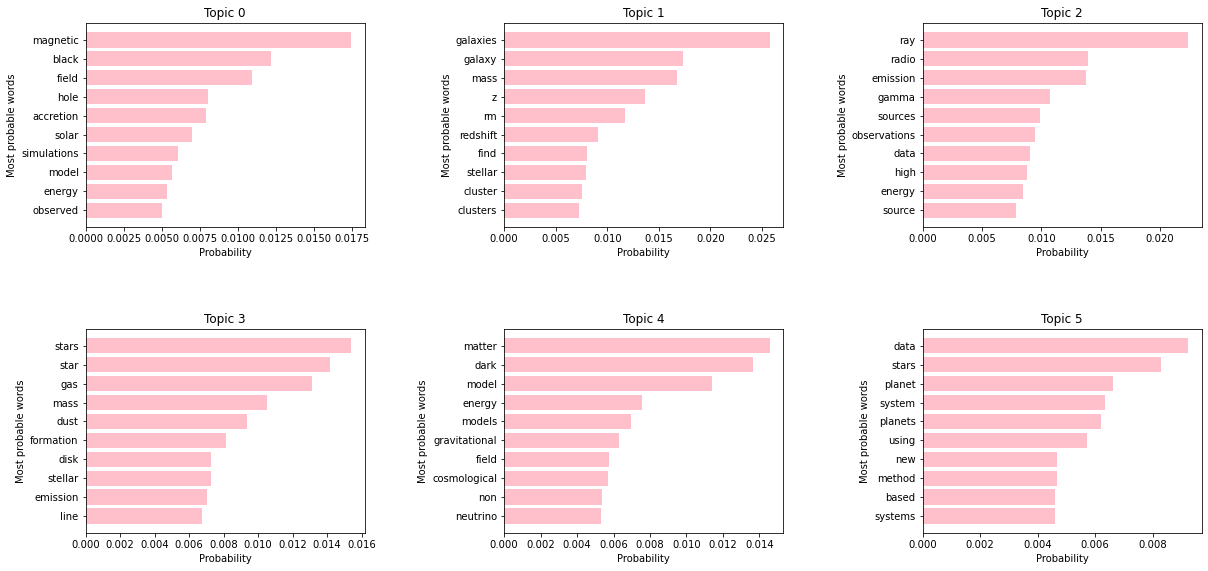

In [670]:
def plot_top_words(model, num_topics, num_words):
    top_words = [[word for word,_ in model.show_topic(topic, topn=10)] for topic in range(num_topics)]
    top_freqs = [[beta for _,beta in model.show_topic(topic, topn=10)] for topic in range(num_topics)]
    gs = GridSpec(round(math.sqrt(num_topics))+1, round(math.sqrt(num_topics))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(num_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_words), top_betas[i][:num_words], align='center', color='pink', ecolor='gray')
        ax.invert_yaxis()
        ax.set_yticks(range(num_words))
        ax.set_xlabel('Probability')
        ax.set_ylabel('Most probable words')
        ax.set_yticklabels(top_words[i][:num_words])
        plt.title('Topic ' + str(i))
        
plot_top_words(lda_model, lda_model.num_topics, 10)

Visualize using pyLDAvis.

In [605]:
vis = pyLDAvis.gensim.prepare(lda_model1, bow, dictionary=lda_model1.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.144847 -0.076541       1        1  18.922424
0      0.147220  0.080432       2        1  18.898009
4     -0.055985  0.103342       3        1  16.869796
3     -0.069376 -0.124400       4        1  16.268876
5     -0.118754  0.039209       5        1  15.165396
1     -0.047951 -0.022042       6        1  13.875499, topic_info=         Term          Freq         Total Category  logprob  loglift
298  galaxies  75412.000000  75412.000000  Default  30.0000  30.0000
121       ray  65861.000000  65861.000000  Default  29.0000  29.0000
146  emission  64095.000000  64095.000000  Default  28.0000  28.0000
524     stars  78636.000000  78636.000000  Default  27.0000  27.0000
153    galaxy  55869.000000  55869.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
190      data   9602.105110  74940.690704   Topic6  -5.4748  -0.0797
230      also   8322.374936  57232.626982   Topic6  -5.6178   0.0469
119   present   7652.409602  52415.253854   Topic6  -5.7018   0.0509
34       find   7557.009205  63797.701656   Topic6  -5.7143  -0.1582
717      high   7451.677812  68300.954868   Topic6  -5.7283  -0.2404

[595 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1124       1  0.000388  abundance
1124       2  0.117288  abundance
1124       3  0.080184  abundance
1124       4  0.002717  abundance
1124       5  0.799279  abundance
...      ...       ...        ...
5089       1  0.998829      zonal
14491      1  0.003926       zoom
14491      3  0.991309       zoom
14491      4  0.003926       zoom
5888       5  0.997854         zr

[1796 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 6, 2])

Perhaps...?


- 6 - Earth and planetary astrophysics — astro-ph.EP
- 5 - Instrumentation and methods for astrophysics — astro-ph.IM
- 4 - High energy astrophysical phenomena — astro-ph.HE
- 3 - Cosmology and non-galactic astrophysics - astro-ph.CO
- 2 - Solar and stellar astrophysics — astro-ph.SR
- 1 - Astrophysics of galaxies — astro-ph.GA

Format topic weights into dataframe.

In [6]:
topics_df = pd.DataFrame([dict(doc) for doc in lda_model[bow]]).fillna(0).sort_index(axis=1)
topics_df

,0,1,2,3,4,5
0,0.000000,0.000000,0.851655,0.029317,0.114035,0.000000
1,0.029015,0.000000,0.617370,0.242855,0.105947,0.000000
2,0.222159,0.000000,0.084439,0.245072,0.443583,0.000000
3,0.070000,0.000000,0.000000,0.116404,0.806211,0.000000
4,0.000000,0.000000,0.988506,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
145432,0.000000,0.000000,0.000000,0.270657,0.463682,0.258854
145433,0.000000,0.000000,0.127901,0.000000,0.867233,0.000000
145434,0.000000,0.000000,0.100624,0.000000,0.892910,0.000000
145435,0.000000,0.000000,0.202787,0.789573,0.000000,0.000000


Count topic occurrences—remember each paper can have more than 1 topic.

In [343]:
(topics_df != 0).sum(0)

0    68345
1    90194
2    72084
3    71535
4    75364
5    85030
dtype: int64

Compare this distribution to actual subcategory distribution:

In [347]:
subcat_count = Counter(x for xs in corpus['subcategories'] for x in set(xs))
subcat_count

Counter({'astro-ph.CO': 44924,
         'astro-ph.GA': 37270,
         'astro-ph.HE': 34036,
         'astro-ph.SR': 38090,
         'astro-ph.IM': 14174,
         'astro-ph.EP': 14706})

Collect main topic of each document.

In [7]:
main_topics = topics_df.idxmax(axis=1)
main_topics

0         2
1         2
2         4
3         4
4         2
         ..
145432    4
145433    4
145434    4
145435    3
145436    4
Length: 145437, dtype: int64

Get list of actual topics per document, minus weights of 0. 

In [659]:
df = topics_df.apply(lambda x: x > 0)
topics = df.apply(lambda x: list(df.columns[x.values]), axis=1)
topics

0            [1, 2, 5]
1         [1, 2, 4, 5]
2         [1, 2, 4, 5]
3               [2, 5]
4                  [1]
              ...     
145432       [0, 2, 5]
145433          [1, 2]
145434          [1, 2]
145435       [1, 3, 5]
145436       [1, 4, 5]
Length: 145437, dtype: object

In [394]:
document1 = lda_model[corpus_bow][0]
document2 = lda_model[corpus_bow][1]
gensim.matutils.hellinger(document1, document2)

0.32427367454807676

### PCA

Generate from the original 6 dimensions, the first three principal components.

In [731]:
pca = PCA(n_components=3)
pca_3 = pca.fit_transform(topics_df)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.30679733 0.19684384 0.17551111]


The first three components account for about 68 percent of the variation in the entire dataset. This should be enough to visually set the different documents apart. We do this by creating a scatterplot of the principal components and coloring each document's subcategory (the main one, for the sake of visualization) with a different color. If documents from the same subdomain are clustered together in groups, this would mean that the first three principal components actually tell us a great deal about the specific subdomains of the documents. 

In [732]:
pca_3.shape

(145437, 3)

Visualize 2D.

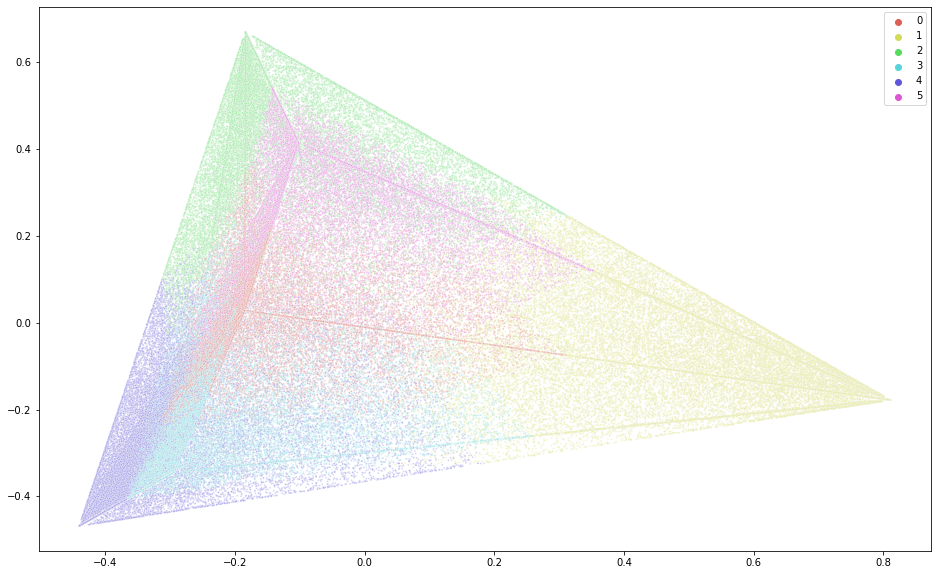

In [733]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_3[:,0],
    y=pca_3[:,1],
    alpha=0.3,
    s=3,
    hue=main_topics,
    palette=sns.color_palette("hls", lda_model.num_topics)
)

Visualize 3D.

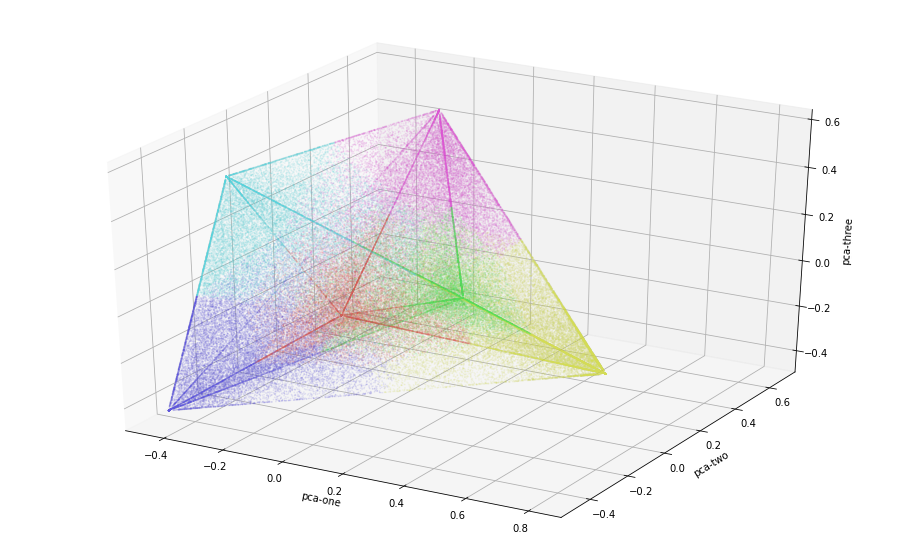

In [735]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_3[:,0], 
    ys=pca_3[:,1], 
    zs=pca_3[:,2], 
    c=main_topics, 
    alpha=0.1,
    cmap=ListedColormap(sns.color_palette("hls", lda_model.num_topics)),
    s=0.5
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

I wonder why there are solid line shaped clusters at the edges. Colors do not seem consistent between both plots—topic 0 may have a different color in the first plot compared to topic 0 in the second plot. Need to add a legend to the second plot.

### t-SNE

t-SNE is another technique that we can use to reduce the number of dimensions that may prove more helpful than PCA.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or Truncated SVD for sparse data) to reduce teh number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. Here they are not, so we will go straight to t-SNE.

In [15]:
tsne2_path = GLOBALS['absolute_filepaths']['lda'] + 'tsne2.npy'
if not os.path.exists(tsne2_path):
    tsne = TSNE(n_components=2, verbose=1)
    tsne2 = tsne.fit_transform(topics_df)
    np.save(tsne2_path, tsne2)
else:
    tsne2 = np.load(tsne2_path)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 145437 samples in 6.036s...
[t-SNE] Computed neighbors for 145437 samples in 14.468s...
[t-SNE] Computed conditional probabilities for sample 1000 / 145437
[t-SNE] Computed conditional probabilities for sample 2000 / 145437
[t-SNE] Computed conditional probabilities for sample 3000 / 145437
[t-SNE] Computed conditional probabilities for sample 4000 / 145437
[t-SNE] Computed conditional probabilities for sample 5000 / 145437
[t-SNE] Computed conditional probabilities for sample 6000 / 145437
[t-SNE] Computed conditional probabilities for sample 7000 / 145437
[t-SNE] Computed conditional probabilities for sample 8000 / 145437
[t-SNE] Computed conditional probabilities for sample 9000 / 145437
[t-SNE] Computed conditional probabilities for sample 10000 / 145437
[t-SNE] Computed conditional probabilities for sample 11000 / 145437
[t-SNE] Computed conditional probabilities for sample 12000 / 145437
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 118000 / 145437
[t-SNE] Computed conditional probabilities for sample 119000 / 145437
[t-SNE] Computed conditional probabilities for sample 120000 / 145437
[t-SNE] Computed conditional probabilities for sample 121000 / 145437
[t-SNE] Computed conditional probabilities for sample 122000 / 145437
[t-SNE] Computed conditional probabilities for sample 123000 / 145437
[t-SNE] Computed conditional probabilities for sample 124000 / 145437
[t-SNE] Computed conditional probabilities for sample 125000 / 145437
[t-SNE] Computed conditional probabilities for sample 126000 / 145437
[t-SNE] Computed conditional probabilities for sample 127000 / 145437
[t-SNE] Computed conditional probabilities for sample 128000 / 145437
[t-SNE] Computed conditional probabilities for sample 129000 / 145437
[t-SNE] Computed conditional probabilities for sample 130000 / 145437
[t-SNE] Computed conditional probabilities for sample 131000 / 145437
[t-SNE] Computed con

Visualize in 2D.

INFO : NumExpr defaulting to 4 threads.


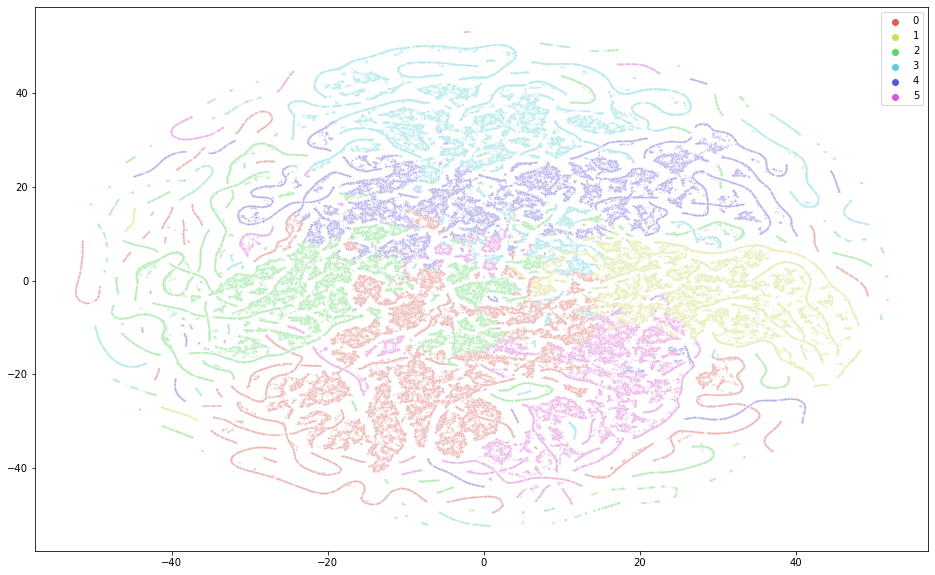

In [21]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=[i[0] for i in tsne2],
    y=[i[1] for i in tsne2],
    alpha=0.3,
    s=3,
    hue=main_topics,
    legend='full',
    palette=sns.color_palette("hls", lda_model.num_topics)
)

Get 3D.

Default values of t-SNE: 
- perplexity = 30
- n_iter = 1000

In [25]:
# NEED TO IMPORT DIFFERENT TSNE, WORKING WITH SPORC ON THIS
tsne = TSNE(n_components=2,
            perplexity=100,
            n_iter=5000,
            verbose=1)
tsne2_100_5000 = tsne.fit_transform(topics_df)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 145437 samples in 6.211s...
[t-SNE] Computed neighbors for 145437 samples in 38.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 145437
[t-SNE] Computed conditional probabilities for sample 2000 / 145437
[t-SNE] Computed conditional probabilities for sample 3000 / 145437
[t-SNE] Computed conditional probabilities for sample 4000 / 145437
[t-SNE] Computed conditional probabilities for sample 5000 / 145437
[t-SNE] Computed conditional probabilities for sample 6000 / 145437
[t-SNE] Computed conditional probabilities for sample 7000 / 145437
[t-SNE] Computed conditional probabilities for sample 8000 / 145437
[t-SNE] Computed conditional probabilities for sample 9000 / 145437
[t-SNE] Computed conditional probabilities for sample 10000 / 145437
[t-SNE] Computed conditional probabilities for sample 11000 / 145437
[t-SNE] Computed conditional probabilities for sample 12000 / 145437
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 118000 / 145437
[t-SNE] Computed conditional probabilities for sample 119000 / 145437
[t-SNE] Computed conditional probabilities for sample 120000 / 145437
[t-SNE] Computed conditional probabilities for sample 121000 / 145437
[t-SNE] Computed conditional probabilities for sample 122000 / 145437
[t-SNE] Computed conditional probabilities for sample 123000 / 145437
[t-SNE] Computed conditional probabilities for sample 124000 / 145437
[t-SNE] Computed conditional probabilities for sample 125000 / 145437
[t-SNE] Computed conditional probabilities for sample 126000 / 145437
[t-SNE] Computed conditional probabilities for sample 127000 / 145437
[t-SNE] Computed conditional probabilities for sample 128000 / 145437
[t-SNE] Computed conditional probabilities for sample 129000 / 145437
[t-SNE] Computed conditional probabilities for sample 130000 / 145437
[t-SNE] Computed conditional probabilities for sample 131000 / 145437
[t-SNE] Computed con

KeyboardInterrupt: 

Viisualize in R using scatterpie plot. https://towardsdatascience.com/visualizing-topic-models-with-scatterpies-and-t-sne-f21f228f7b02

## 4. Evaluate

Load triplets and define evaluate function. Note that I could use similarity matrix here, but I chose to make it quicker by only calculating one cosine similarity instead of loading a whole matrix for one paper—the similarity matrix also uses cosine similarity.

In [719]:
triplets = np.load('../src/sporc/20000_triplets.npy')

def evaluate(triplets):
    '''Calculates averaged accuracy of all given triplets,
    that ab is more similar than ac. 
    Hellinger distance metric gives an output in the range [0, 1] 
    for two probability distributions, 
    with values closer to 0 meaning they are more similar.'''
    print('Evaluating...')
    accuracy_hellinger = 0
    accuracy_cosine = 0
    
    for triplet in triplets:
        # Get filenames of papers A, B, C
        a_idx = corpus_ids.index(triplet[0])
        b_idx = corpus_ids.index(triplet[1])
        c_idx = corpus_ids.index(triplet[2])

        # Get vectors of papers A, B, C (for Hellinger distance)
        a = lda_model[bow][a_idx]
        b = lda_model[bow][b_idx]
        c = lda_model[bow][c_idx]

        # Calculate Hellinger and cosine distances
        ab_hellinger = gensim.matutils.hellinger(a, b)
        ac_hellinger = gensim.matutils.hellinger(a, c)
        ab_cosine = gensim.matutils.cossim(a, b)
        ac_cosine = gensim.matutils.cossim(a, c)
        
        # Calculate accuracy for both distances
        if ab_hellinger > ac_hellinger:
            accuracy_hellinger += 1
        if ab_cosine > ac_cosine:
            accuracy_cosine += 1
    return {'hellinger': accuracy_hellinger/len(triplets),
            'cosine': accuracy_cosine/len(triplets)}

In [720]:
evaluate(triplets)

Evaluating...


{'hellinger': 0.31185, 'cosine': 0.68115}

## 5. Recommending papers 

Load similarity matrix.

In [ ]:
simatrix_path = GLOBALS['absolute_filepaths']['lda'] + 'similarity.index'
if not os.path.exists(simatrix_path):
    simatrix = gensim.similarities.Similarity(corpus=lda_model[bow],
                                              num_features=len(dictionary),
                                              output_prefix='similarities')
    simatrix.save(simatrix_path)
else:
    gensim.similarities.Similarity.load(simatrix_path)

Find the nearest neighbors to paper 1211.1013.

In [689]:
test_paper = lda_model[bow][corpus_ids.index('1211.1013')]
test_sims = sorted(enumerate(simatrix[test_paper]), key=lambda item: -item[1])
for i in test_sims[:10]:
    print(corpus_ids[i[0]] + ' has a similarity of ' + str(i[1]))

1211.1013 has a similarity of 1.0
1701.02994 has a similarity of 0.9999386
1904.11664 has a similarity of 0.9999204
1103.4127 has a similarity of 0.9999164
1403.3238 has a similarity of 0.9999143
1005.3461 has a similarity of 0.99987257
1301.7687 has a similarity of 0.9998569
1312.6063 has a similarity of 0.9998227
1702.03170 has a similarity of 0.9997918
1512.07088 has a similarity of 0.9997915


Query a sentence: "Numerical simulations of core collapse supernovae driven by neutrino heating." Ideally we should preprocess this the same way as our model's corpus was preprocessed. 

In [690]:
query = "Numerical simulations core collapse supernovae driven neutrino heating"
query_bow = dictionary.doc2bow(query.lower().split(' '))
query_sims = simatrix[lda_model[query_bow]]
query_sims = sorted(enumerate(query_sims), key=lambda item: -item[1])

# Get arxiv id for each nearest neighbor
arxiv_ids = []
for i in query_sims[:5]:
    print(corpus_ids[i[0]] + ' has a similarity of ' + str(i[1]))

1001.1355 has a similarity of 0.9996714
1408.0778 has a similarity of 0.9990829
1606.05055 has a similarity of 0.99891967
1907.05239 has a similarity of 0.998919
0908.2806 has a similarity of 0.9989042
